In [1]:
# === Шаг 1: Импорт необходимых библиотек ===
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import os # Добавим для удобной работы с путями

# === Шаг 2: Настройка и загрузка модели (делается один раз) ===

# Проверяем доступность CUDA и устанавливаем устройство
if torch.cuda.is_available():
    device = "cuda"
    print(f"CUDA доступна! Используем GPU: {torch.cuda.get_device_name(0)}")
else:
    device = "cpu"
    print("CUDA недоступна, используется CPU. Это будет медленно.")

# Пути к модели
model_checkpoint_path = "/app/MODELS/sam_vit_h_4b8939.pth"
model_type = "vit_h"

# Загружаем модель в память
print("\nЗагрузка модели Segment Anything...")
sam = sam_model_registry[model_type](checkpoint=model_checkpoint_path)
sam.to(device=device)
print("Модель успешно загружена.")

# Инициализируем генератор масок
mask_generator = SamAutomaticMaskGenerator(sam)
print("Генератор автоматических масок готов.")

CUDA доступна! Используем GPU: NVIDIA GeForce RTX 3080 Ti

Загрузка модели Segment Anything...
Модель успешно загружена.
Генератор автоматических масок готов.



--- Обработка изображения: 1_normals.jpg ---
Изображение успешно загружено. Размер: (2151, 5493, 3)
Запускаю автоматическую сегментацию (это может занять время)...
Готово! Найдено 35 масок.

Сохранение 35 масок в папку 'all_generated_masks'...
Все 35 маски сохранены.

Подготовка итоговой визуализации...


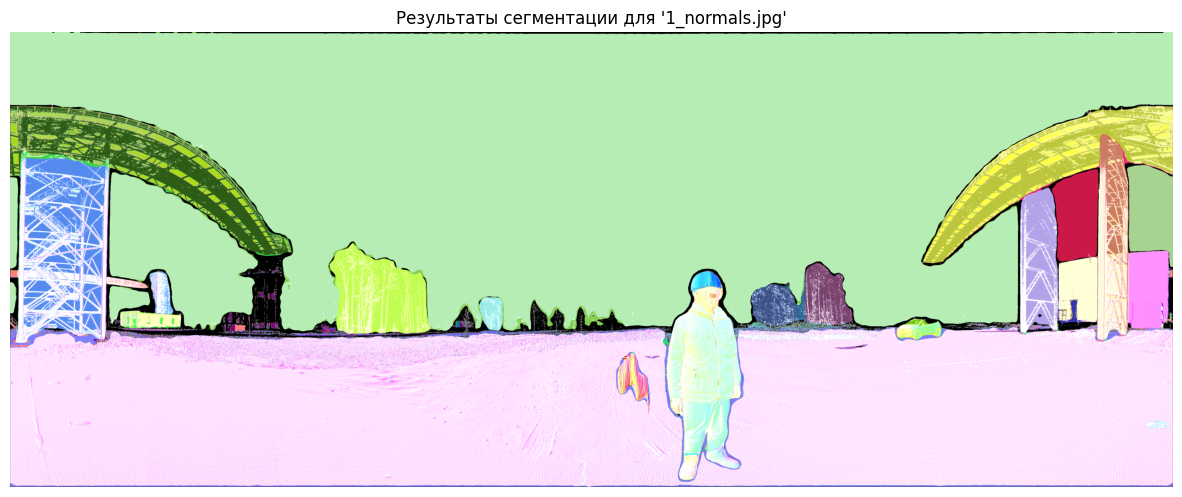

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Шаг 3: Обработка вашего изображения ===

image_path = "/app/Vistino20241014_E57/1_normals.jpg"
output_mask_dir = "all_generated_masks" 
os.makedirs(output_mask_dir, exist_ok=True) 

image_name = os.path.basename(image_path)
print(f"\n--- Обработка изображения: {image_name} ---")

try:
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Не удалось загрузить изображение. Проверьте путь: {image_path}")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    print(f"Изображение успешно загружено. Размер: {image_rgb.shape}")
    print("Запускаю автоматическую сегментацию (это может занять время)...")
    masks = mask_generator.generate(image_rgb)
    print(f"Готово! Найдено {len(masks)} масок.")
except Exception as e:
    print(f"Произошла ошибка: {e}")
    masks = []

# === Шаг 4: Сохранение найденных масок ===

if masks:
    print(f"\nСохранение {len(masks)} масок в папку '{output_mask_dir}'...")
    for i, ann in enumerate(masks):
        boolean_mask = ann['segmentation']
        image_mask = (boolean_mask * 255).astype(np.uint8)
        filename = f"mask_{i}.png"
        filepath = os.path.join(output_mask_dir, filename)
        cv2.imwrite(filepath, image_mask)
    print(f"Все {len(masks)} маски сохранены.")

# === ИСПРАВЛЕННЫЙ ШАГ 5: Визуализация результатов ===

def show_anns_on_image(image_rgb, anns):
    """
    Создает новое изображение, корректно накладывая полупрозрачные маски.
    """
    if not anns:
        print("Нет масок для отображения.")
        return image_rgb
    
    # Создаем копию изображения, на которой будем рисовать
    img = image_rgb.copy()
    # Создаем пустой "слой" для наложения масок с альфа-каналом (прозрачностью)
    overlay = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
    
    # Сортируем маски, чтобы самые большие рисовались первыми
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    for ann in sorted_anns:
        m = ann['segmentation']
        # Генерируем случайный цвет для маски
        random_color = np.random.randint(0, 256, 3)
        # Устанавливаем цвет и прозрачность на нашем слое
        overlay[m, :3] = random_color
        overlay[m, 3] = 150 # Устанавливаем полупрозрачность (от 0 до 255)

    # Конвертируем исходное изображение в RGBA, чтобы их можно было смешать
    img_rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
    
    # Смешиваем исходное изображение с нашим слоем масок
    final_image = cv2.addWeighted(img_rgba, 1.0, overlay, 1.0, 0)
    
    # Конвертируем обратно в RGB для отображения в Matplotlib
    final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_RGBA2RGB)
    
    return final_image_rgb

# Если маски были найдены, отображаем результат
if masks:
    print("\nПодготовка итоговой визуализации...")
    result_image = show_anns_on_image(image_rgb, masks)

    plt.figure(figsize=(15, 10))
    plt.imshow(result_image)
    plt.axis('off')
    plt.title(f"Результаты сегментации для '{image_name}'")
    plt.show()

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- НАСТРОЙКИ ---
panorama_dir = "Vistino20241014_E57" 
source_dir = "all_generated_masks"
classified_dir = "classified_masks"
os.makedirs(classified_dir, exist_ok=True)

panorama_base_name = "1_normals" 
HIGHLIGHT_COLOR = (0, 255, 0)

# --- ВАШИ КЛАССЫ (из скриншота) ---
CLASS_NAMES = ["Фон", "Земля", "Человек", "Растительность", "Транспорт", "Конструкции", "Здание"]

# --- ГЛОБАЛЬНЫЕ ПЕРЕМЕННЫЕ ДЛЯ УПРАВЛЕНИЯ СОСТОЯНИЕМ ---
# Загружаем список масок один раз
mask_files = sorted(os.listdir(source_dir))
# Индекс текущей маски, которую мы показываем
current_mask_index = 0

# --- ЗАГРУЗКА ПАНОРАМЫ ---
original_panorama = None
if mask_files:
    for ext in ['.png', '.jpg', '.jpeg']:
        panorama_path = os.path.join(panorama_dir, f"{panorama_base_name}{ext}")
        if os.path.exists(panorama_path):
            original_panorama = cv2.imread(panorama_path)
            print(f"✅ Панорама успешно найдена: {panorama_path}")
            break
    if original_panorama is None:
        print(f"❌ ОШИБКА: Не могу найти файл панорамы '{panorama_base_name}' в папке '{panorama_dir}'.")
        mask_files = [] # Обнуляем, чтобы остановить выполнение
    else:
        original_panorama_rgb = cv2.cvtColor(original_panorama, cv2.COLOR_BGR2RGB)

# --- СОЗДАНИЕ ИНТЕРАКТИВНЫХ ВИДЖЕТОВ ---

# 1. Создаем область вывода, куда будем рисовать картинки
output_area = widgets.Output()

# 2. Создаем кнопки для каждого класса
# Используем HBox для расположения кнопок в ряд
class_buttons = [widgets.Button(description=name, button_style='primary') for name in CLASS_NAMES]
# Добавляем кнопки для управления
skip_button = widgets.Button(description="Пропустить", button_style='info')
stop_button = widgets.Button(description="Стоп", button_style='danger')

# Собираем все кнопки в один контейнер
button_box = widgets.HBox(class_buttons + [skip_button, stop_button])


# --- ЛОГИКА ПРИЛОЖЕНИЯ ---

def display_current_mask():
    """Функция для отображения текущей маски в output_area."""
    global current_mask_index
    
    # Если маски закончились, выводим сообщение о завершении
    if current_mask_index >= len(mask_files):
        with output_area:
            clear_output()
            print("🎉 Все маски классифицированы! Процесс завершен. 🎉")
            # Деактивируем кнопки
            for btn in class_buttons + [skip_button, stop_button]:
                btn.disabled = True
        return
        
    filename = mask_files[current_mask_index]
    
    # Загружаем и готовим изображения
    filepath = os.path.join(source_dir, filename)
    mask_image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    
    overlay = np.zeros_like(original_panorama)
    overlay[mask_image > 0] = HIGHLIGHT_COLOR
    highlighted_image = cv2.addWeighted(original_panorama, 1, overlay, 0.6, 0)
    highlighted_image_rgb = cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB)

    # Используем output_area для контроля над тем, где будет вывод
    with output_area:
        clear_output(wait=True) # Очищаем предыдущий вывод
        
        fig, axes = plt.subplots(3, 1, figsize=(15, 12))
        fig.suptitle(f"Осталось: {len(mask_files) - current_mask_index} масок", fontsize=16)
        
        axes[0].imshow(original_panorama_rgb)
        axes[0].set_title("1. Оригинальная панорама")
        axes[0].axis('off')

        axes[1].imshow(mask_image, cmap='gray')
        axes[1].set_title(f"2. Текущая маска: {filename}")
        axes[1].axis('off')
        
        axes[2].imshow(highlighted_image_rgb)
        axes[2].set_title("3. Подсветка этой маски на панораме")
        axes[2].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def on_button_click(button):
    """Эта функция вызывается при нажатии ЛЮБОЙ кнопки."""
    global current_mask_index
    
    action = button.description
    filename = mask_files[current_mask_index]

    if action == "Стоп":
        with output_area:
            clear_output()
            print("Процесс остановлен пользователем.")
            # Деактивируем все кнопки
            for btn in class_buttons + [skip_button, stop_button]:
                btn.disabled = True
        return
        
    elif action == "Пропустить":
        print(f"Пропускаем {filename}...")
        # Ничего не сохраняем, просто готовимся к следующей маске
        
    else: # Если нажата кнопка одного из классов
        class_name = action
        clean_class_name = class_name.strip().replace(" ", "_")
        new_filename = f"{panorama_base_name}_{clean_class_name}_{current_mask_index}.png" # Добавил индекс для уникальности
        
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(classified_dir, new_filename)
        
        os.rename(source_path, destination_path)
        print(f"Файл '{filename}' классифицирован как '{class_name}' и сохранен.")

    # Переходим к следующей маске и отображаем ее
    current_mask_index += 1
    display_current_mask()


# --- ЗАПУСК ---

# Привязываем нашу функцию-обработчик к каждой кнопке
for btn in class_buttons + [skip_button, stop_button]:
    btn.on_click(on_button_click)

# Отображаем интерфейс: сначала кнопки, потом область для картинок
if mask_files:
    print("--- Начинаем процесс классификации масок ---")
    print("Просто нажимайте на кнопки с нужным классом.")
    display(button_box, output_area)
    # Запускаем отображение первой маски
    display_current_mask()
else:
    print("--- Нет масок для классификации. Проверьте папку 'all_generated_masks' ---")

✅ Панорама успешно найдена: Vistino20241014_E57/1_normals.jpg
--- Начинаем процесс классификации масок ---
Просто нажимайте на кнопки с нужным классом.


Output()

--- Начинаем сборку финальной маски для CVAT (v2) ---
Размеры панорамы определены: 5493x2151

----------------------------------------------------
✅ Готово! Финальная маска сохранена по пути: classified_masks_CVAT/1_normals_mask.png
Файл выглядит темным, но содержит правильные данные для CVAT.


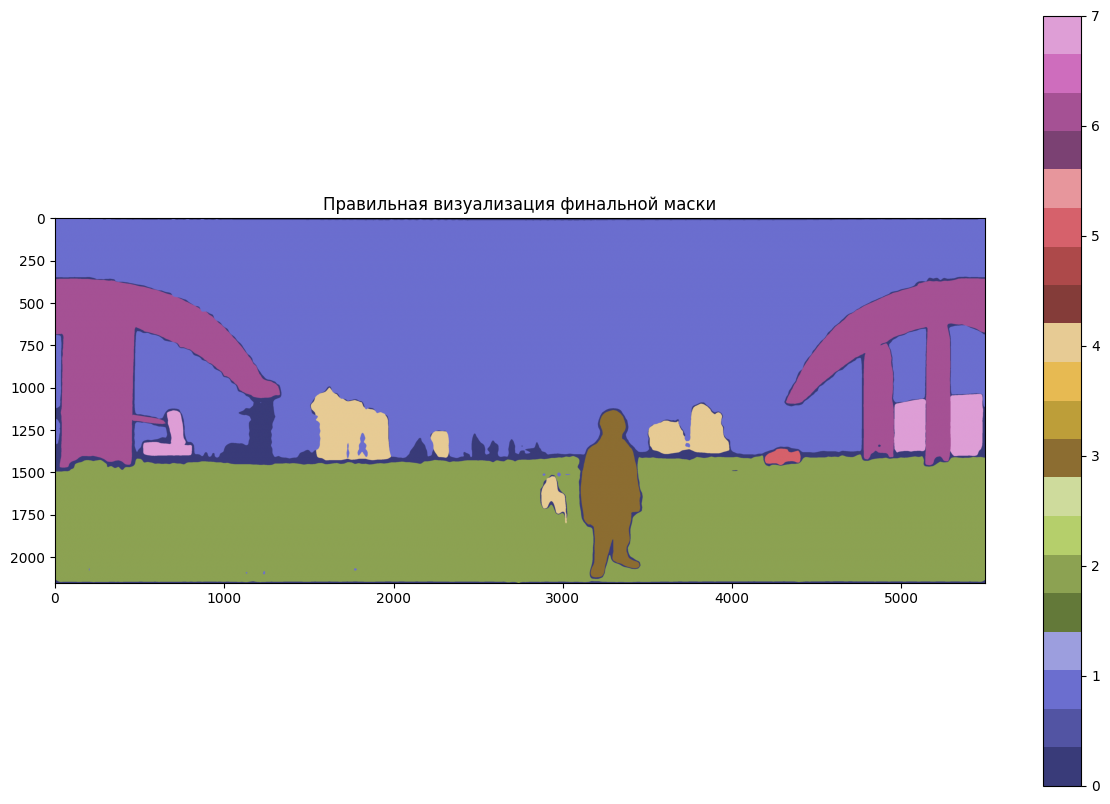

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- НАСТРОЙКИ ---
classified_dir = "classified_masks"
panorama_dir = "Vistino20241014_E57" 
panorama_base_name = "1_normals"
output_dir = "classified_masks_CVAT"
os.makedirs(output_dir, exist_ok=True)
final_mask_path = os.path.join(output_dir, f"{panorama_base_name}_mask.png")

CLASS_MAPPING = {
    "Фон": 1, "Земля": 2, "Человек": 3, "Растительность": 4,
    "Транспорт": 5, "Конструкции": 6, "Здание": 7,
}

print("--- Начинаем сборку финальной маски для CVAT (v2) ---")

# --- ЗАГРУЗКА ПАНОРАМЫ  ---
try:
    panorama_path = None
    for ext in ['.png', '.jpg', '.jpeg']:
        path_try = os.path.join(panorama_dir, f"{panorama_base_name}{ext}")
        if os.path.exists(path_try):
            panorama_path = path_try
            break
    if panorama_path is None: raise FileNotFoundError
    image_for_size = cv2.imread(panorama_path, cv2.IMREAD_GRAYSCALE)
    height, width = image_for_size.shape
    print(f"Размеры панорамы определены: {width}x{height}")
except FileNotFoundError:
    print(f"❌ ОШИБКА: Не могу найти исходную панораму.")
    exit()

# --- ОСНОВНОЙ ЦИКЛ СБОРКИ  ---
final_mask = np.zeros((height, width), dtype=np.uint8)

file_list = sorted(os.listdir(classified_dir))
if not file_list:
    print("❌ ОШИБКА: Папка с классифицированными масками пуста!")
else:
    for filename in file_list:
        # Игнорируем системные папки типа .ipynb_checkpoints
        if not filename.endswith('.png'):
            continue

        # --- ИСПРАВЛЕННАЯ ЛОГИКА ПАРСИНГА ---
        # 1. Отделяем имя файла от расширения
        file_stem = os.path.splitext(filename)[0]
        # 2. Разбираем имя
        parts = file_stem.split('_')
        
        # 3. Проверяем, достаточно ли частей в имени
        if len(parts) >= 3:
            # Класс - это третья часть имени
            class_name = parts[2]
            
            if class_name in CLASS_MAPPING:
                class_id = CLASS_MAPPING[class_name]
                mask_path = os.path.join(classified_dir, filename)
                binary_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                if binary_mask is not None:
                    final_mask[binary_mask > 0] = class_id
                else:
                    print(f"⚠️ Предупреждение: Не удалось прочитать файл маски '{filename}'.")
            else:
                print(f"⚠️ Предупреждение: Класс '{class_name}' из файла '{filename}' не найден в CLASS_MAPPING.")
        else:
            print(f"⚠️ Предупреждение: Не удалось разобрать имя файла '{filename}'. Пропускаю.")


# --- Сохранение и визуализация ---
cv2.imwrite(final_mask_path, final_mask)
print("\n----------------------------------------------------")
print(f"✅ Готово! Финальная маска сохранена по пути: {final_mask_path}")
print("Файл выглядит темным, но содержит правильные данные для CVAT.")

plt.figure(figsize=(15, 10))
plt.imshow(final_mask, cmap='tab20b') 
plt.title("Правильная визуализация финальной маски")
plt.colorbar()
plt.show()

In [13]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from xml.dom import minidom
import zipfile

# --- НАСТРОЙКИ ---
panorama_base_name = "1_normals"
panorama_dir = "Vistino20241014_E57" 
final_mask_dir = "classified_masks_CVAT"
output_dir = "labelme_dataset"
os.makedirs(output_dir, exist_ok=True)

CLASS_MAPPING = {
    "Фон": 1, "Земля": 2, "Человек": 3, "Растительность": 4,
    "Транспорт": 5, "Конструкции": 6, "Здание": 7,
}
ID_TO_NAME = {v: k for k, v in CLASS_MAPPING.items()}


print("--- Создаем датасет в формате LabelMe XML ---")

# --- 1. Загружаем финальную маску ---
mask_path = os.path.join(final_mask_dir, f"{panorama_base_name}_mask.png")
if not os.path.exists(mask_path):
    print(f"❌ ОШИБКА: Не могу найти собранную маску: {mask_path}")
    exit()
final_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
height, width = final_mask.shape

# --- 2. Создаем основу XML документа ---
annotation = ET.Element('annotation')
# Находим расширение оригинального файла
original_panorama_path = None
for ext in ['.jpg', '.png', '.jpeg']:
    path_try = os.path.join(panorama_dir, f"{panorama_base_name}{ext}")
    if os.path.exists(path_try):
        original_panorama_path = path_try
        break
if not original_panorama_path:
    print(f"❌ ОШИБКА: Не могу найти оригинальную панораму {panorama_base_name} в папке {panorama_dir}")
    exit()

ET.SubElement(annotation, 'filename').text = os.path.basename(original_panorama_path)
ET.SubElement(annotation, 'folder').text = '' # Оставляем пустым
imagesize = ET.SubElement(annotation, 'imagesize')
ET.SubElement(imagesize, 'nrows').text = str(height)
ET.SubElement(imagesize, 'ncols').text = str(width)

# --- 3. Находим контуры и добавляем объекты в XML ---
print("Начинаю поиск контуров...")
object_counter = 0
for class_id, class_name in ID_TO_NAME.items():
    if class_name == "Фон": continue
    binary_mask = np.uint8(final_mask == class_id) * 255
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: continue
    print(f"  > Найдено {len(contours)} объектов для класса '{class_name}'")
    for contour in contours:
        if cv2.contourArea(contour) < 5: continue
        obj = ET.SubElement(annotation, 'object')
        ET.SubElement(obj, 'name').text = class_name
        ET.SubElement(obj, 'deleted').text = '0'
        ET.SubElement(obj, 'id').text = str(object_counter)
        object_counter += 1
        polygon = ET.SubElement(obj, 'polygon')
        for point in contour.squeeze():
            pt = ET.SubElement(polygon, 'pt')
            ET.SubElement(pt, 'x').text = str(int(point[0]))
            ET.SubElement(pt, 'y').text = str(int(point[1]))

# --- 4. Сохраняем XML-файл ---
xml_string = ET.tostring(annotation, 'utf-8')
reparsed = minidom.parseString(xml_string)
pretty_xml_string = '\n'.join(reparsed.toprettyxml(indent="  ").split('\n')[1:])
final_xml_output = '<?xml version="1.0" encoding="UTF-8"?>\n' + pretty_xml_string
xml_filepath = os.path.join(output_dir, f"{panorama_base_name}.xml")
with open(xml_filepath, 'w', encoding='utf-8') as f:
    f.write(final_xml_output)
print(f"✅ XML-аннотация сохранена: {xml_filepath}")

# --- НОВЫЙ ШАГ 5: Создание финального ZIP-архива ---
print("\n--- Создание ZIP-архива для загрузки в CVAT ---")
zip_filepath = os.path.join(output_dir, f"{panorama_base_name}.zip")

try:
    with zipfile.ZipFile(zip_filepath, 'w') as zipf:
        # Добавляем в архив оригинальную панораму
        zipf.write(original_panorama_path, arcname=os.path.basename(original_panorama_path))
        print(f"  + Добавлен файл: {os.path.basename(original_panorama_path)}")
        
        # Добавляем в архив сгенерированный XML
        zipf.write(xml_filepath, arcname=os.path.basename(xml_filepath))
        print(f"  + Добавлен файл: {os.path.basename(xml_filepath)}")

    print("\n----------------------------------------------------")
    print(f"ZIP-архив готов для загрузки в CVAT:")
    print(f"{zip_filepath}")

except Exception as e:
    print(f"\n❌ ОШИБКА при создании ZIP-архива: {e}")

--- Создаем датасет в формате LabelMe XML ---
Начинаю поиск контуров...
  > Найдено 1 объектов для класса 'Земля'
  > Найдено 1 объектов для класса 'Человек'
  > Найдено 4 объектов для класса 'Растительность'
  > Найдено 1 объектов для класса 'Транспорт'
  > Найдено 2 объектов для класса 'Конструкции'
  > Найдено 3 объектов для класса 'Здание'
✅ XML-аннотация сохранена: labelme_dataset/1_normals.xml

--- Создание ZIP-архива для загрузки в CVAT ---
  + Добавлен файл: 1_normals.jpg
  + Добавлен файл: 1_normals.xml

----------------------------------------------------
ZIP-архив готов для загрузки в CVAT:
labelme_dataset/1_normals.zip
